<a href="https://colab.research.google.com/github/basakbozkurt/Experiment/blob/main/PowerAnalysis_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -q r-base
!apt-get install -q libcurl4-openssl-dev libssl-dev libxml2-dev
!R -e "install.packages('IRkernel')"
!R -e "IRkernel::installspec(user = FALSE)"


In [3]:
!pip install -q rpy2
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("lme4", repos='http://cran.rstudio.com/')
install.packages("DeclareDesign", repos='http://cran.rstudio.com/')
install.packages("dplyr", repos='http://cran.rstudio.com/')
install.packages("ggplot2", repos='http://cran.rstudio.com/')


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors





Attaching package: ‘DeclareDesign’



    vars



    vars




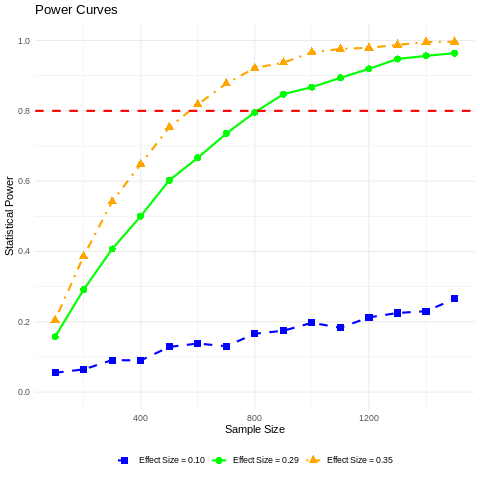

In [5]:
%%R
library(tidyverse)
library(ggplot2)
library(DeclareDesign)


set.seed(123)

#Parameters
treatment_ratio <- 0.6  # 60% treatment, 40% control
alpha <- 0.05
sd_population <- 5
effect_sizes <- c(0.10, 0.29, 0.35)
#effect_sizes <- c(0.10, 0.20, 0.30)


#Simulate nested data with covariates
simulate_data <- function(N_participants, effect_size, N_headlines = 12) {
  participants <- tibble(
    participant = 1:N_participants,
    treatment = rbinom(N_participants, 1, treatment_ratio),
    age = sample(18:75, N_participants, replace = TRUE),
    ideological_alignment = runif(N_participants, -1, 1)
  )

  ratings <- participants %>%
    expand_grid(headline = 1:N_headlines) %>%
    mutate(
      pre_accuracy = rnorm(n(), mean = 50, sd = 15),  # Slightly reduce baseline variation
      post_accuracy = pre_accuracy - (effect_size * treatment) +
        0.1 * age +
        0.2 * ideological_alignment +
        rnorm(n(), mean = 0, sd = sd_population)  # Reduce excess noise
    )

  return(ratings)
}

#Compute power for a given sample size
compute_power <- function(N_participants, effect_size, nsim = 2000) {  # Increased nsim for accuracy
  results <- replicate(nsim, {
    sim_data <- simulate_data(N_participants, effect_size)
    model <- lm(post_accuracy ~ treatment + pre_accuracy + age + ideological_alignment, data = sim_data)
    p_value <- summary(model)$coefficients["treatment", "Pr(>|t|)"]
    return(p_value < alpha)
  })
  mean(results)
}

#Sample sizes and run power simulations
sample_sizes <- seq(100, 1500, by = 100)
power_results <- expand_grid(N_participants = sample_sizes, effect_size = effect_sizes) %>%
  mutate(Power = map2_dbl(N_participants, effect_size, compute_power))

#Convert effect size to a factor for plotting
power_results <- power_results %>%
  mutate(effect_size_label = factor(effect_size, levels = effect_sizes,
                                    labels = c("Effect Size = 0.10",
                                               "Effect Size = 0.29",
                                               "Effect Size = 0.35")))

ggplot(power_results, aes(x = N_participants, y = Power, color = effect_size_label, shape = effect_size_label, linetype = effect_size_label)) +
  geom_point(size = 3) +
  geom_line(size = 1) +
  geom_hline(yintercept = 0.8, linetype = "dashed", color = "red", size = 1) +
  labs(title = "Power Curves",
       x = "Sample Size",
       y = "Statistical Power") +
  scale_y_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.20)) +  # Ensure 0.80 is visible
  scale_color_manual(values = c("blue", "green", "orange")) +
  scale_shape_manual(values = c(15, 16, 17)) +
  scale_linetype_manual(values = c("dashed", "solid", "dotdash")) +
  theme_minimal() +
  theme(legend.title = element_blank(),
        legend.position = "bottom")


